<a href="https://colab.research.google.com/github/vkthakur90/AI_Applications/blob/master/Modern_Portfolio_Theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [ ]:
RISK_FREE_RATE = 7.6

In [ ]:
niftybees_data_df = pd.read_csv('NIFTYBEES.NS.csv')
bankbees_data_df = pd.read_csv('BANKBEES.NS.csv')
goldbees_data_df = pd.read_csv('GOLDBEES.NS.csv')

In [ ]:
def prepare_data(data_df):
    data_df['Date'] = pd.to_datetime(data_df['Date'])
    data_df['days'] = data_df['Date'] - data_df.iloc[0, 0]
    data_df['t'] = data_df['days'].astype('int') / (365 * 24 * 3600 * 1.0e9)
    data_df['S'] = 100 * data_df['Adj Close'] / data_df['Adj Close'][0]
    data_df = data_df[['t', 'S']]

    return data_df

In [ ]:
def calculate_risk_return(data_df):
    mean_series = (
        data_df.eval('ln_S = log(S)')
                    .eval('ln_S_by_t = ln_S / (t + 1.0e-6)')
                    .eval('one_by_t = 1 / (t + 1.0e-6)')
                    .drop(['S'], axis = 1)
                    .mean()
    )

    num = mean_series['ln_S_by_t'] - mean_series['ln_S'] * mean_series['one_by_t']
    den = 1 - mean_series['t'] * mean_series['one_by_t']
    mu = num / den
    alpha = mean_series['ln_S'] - mu * mean_series['t']

    sigma = np.sqrt(data_df.eval('e = (log(S) - @alpha - @mu * t)**2 / (t + 1.0e-6)').mean()['e'])

    return 100 * sigma, 100 * mu

In [ ]:
goldbees_prep_data_df = prepare_data(goldbees_data_df)
bankbees_prep_data_df = prepare_data(bankbees_data_df)
niftybees_prep_data_df = prepare_data(niftybees_data_df)

In [ ]:
data_list = []

for idx in range(100 + 1):
    for jdx in range(100 + 1 - idx):
        t = idx / 100
        u = jdx / 100
        nifty_gold_pf = {'t' : niftybees_prep_data_df['t']}
        nifty_gold_pf.update({f'S': niftybees_prep_data_df['S'] * t + bankbees_prep_data_df['S'] * u + goldbees_prep_data_df['S'] * (1 - t - u) })

        prep_data_df = pd.DataFrame(nifty_gold_pf)
        sigma, mu = calculate_risk_return(prep_data_df)
        sharpe_ratio = (mu - RISK_FREE_RATE) / sigma
        sharpe_ratio = 2.0 * np.floor(sharpe_ratio * 0.5 + 0.5)
        data_list += [[idx, jdx, 100 - idx - jdx, mu, sigma, sharpe_ratio]]

        print(idx, jdx, 100 - idx - jdx, mu, sigma, sharpe_ratio)

Streaming output truncated to the last 5000 lines.
1 50 49 8.236603188764889 3.0312251290861245 0.0
1 51 48 8.392067645298557 3.028161276154723 0.0
1 52 47 8.547387038996304 3.027717318496726 0.0
1 53 46 8.70256166279033 3.0298868052275263 0.0
1 54 45 8.857591808686292 3.034656570715531 0.0
1 55 44 9.012477767760787 3.042006871050893 0.0
1 56 43 9.16721983017198 3.0519116026687922 0.0
1 57 42 9.321818285155466 3.0643385969124006 0.0
1 58 41 9.476273421036872 3.0792499822913584 0.0
1 59 40 9.630585525230071 3.09660260457376 0.0
1 60 39 9.784754884243108 3.1163484937048906 0.0
1 61 38 9.938781783682368 3.1384353659010022 0.0
1 62 37 10.092666508255974 3.1628071491130156 0.0
1 63 36 10.246409341777232 3.1894045203575834 0.0
1 64 35 10.400010567168948 3.2181654441081973 0.0
1 65 34 10.55347046646811 3.2490257019513185 0.0
1 66 33 10.706789320828952 3.2819194049549285 0.0
1 67 32 10.859967410524577 3.3167794815823175 0.0
1 68 31 11.013005014956512 3.3535381354309424 2.0
1 69 30 11.165902412

In [ ]:
pf_df = pd.DataFrame(data_list, columns = ['nifty', 'banknifty', 'gold', 'mu', 'sigma', 'sr'])

In [ ]:
max_sr_df = pf_df[pf_df['sr'] == pf_df['sr'].max()]
min_sigma_max_sr_df = max_sr_df[max_sr_df['sigma'] == max_sr_df['sigma'].min()]
nifty_weight, banknifty_weight, gold_weight = min_sigma_max_sr_df[['nifty', 'banknifty', 'gold']].values.flatten()

In [ ]:
display(min_sigma_max_sr_df)

,nifty,banknifty,gold,mu,sigma,sr
3943,52,17,31,16.351352,2.910912,4.0


<Axes: xlabel='sigma', ylabel='mu'>

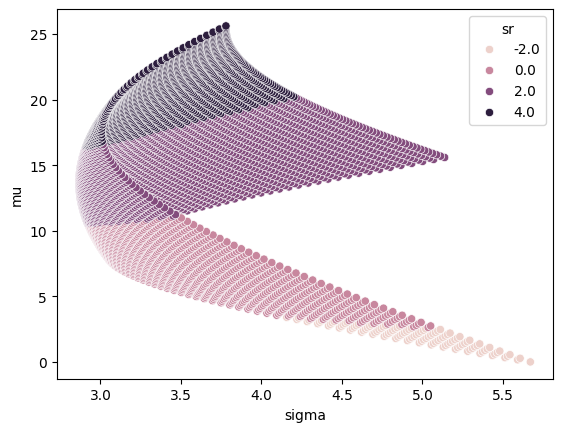

In [ ]:
sns.scatterplot(x = 'sigma', y = 'mu', hue = 'sr', data = pf_df)

In [ ]:
price_df = pd.DataFrame({
    'gold_bees' : goldbees_data_df['Adj Close'],
    'bank_bees' : bankbees_data_df['Adj Close'],
    'nifty_bees' : niftybees_data_df['Adj Close'],
    'prev_gold_bees' : goldbees_data_df['Adj Close'].shift(1),
    'prev_bank_bees' : bankbees_data_df['Adj Close'].shift(1),
    'prev_nifty_bees' : niftybees_data_df['Adj Close'].shift(1),
}).dropna()

In [ ]:
daily_return_df = (
    price_df.eval('gold_bees_return = gold_bees / prev_gold_bees')
            .eval('bank_bees_return = bank_bees / prev_bank_bees')
            .eval('nifty_bees_return = nifty_bees / prev_nifty_bees')
            .drop(price_df.columns, axis = 1)
)

In [ ]:
value = 100000

gold_invested = gold_weight * value / 100
banknifty_invested = banknifty_weight * value / 100
nifty_invested = nifty_weight * value / 100

value_list = [[value, gold_weight, banknifty_weight, nifty_weight, 0]]

for idx, (r_gold, r_bank, r_nifty) in daily_return_df.iterrows():
    new_gold_invested = r_gold * gold_invested
    new_banknifty_invested = r_bank * banknifty_invested
    new_nifty_invested = r_nifty * nifty_invested

    new_value = 0
    new_value += new_gold_invested
    new_value += new_banknifty_invested
    new_value += new_nifty_invested

    gold_percentage = 100 * new_gold_invested / new_value
    banknifty_percentage = 100 * new_banknifty_invested / new_value
    nifty_percentage = 100 * new_nifty_invested / new_value

    rate_of_return = (new_value / value - 1) * 100

    value_list += [[new_value, gold_percentage, banknifty_percentage, nifty_percentage, rate_of_return]]

    gold_invested = gold_weight * new_value / 100
    banknifty_invested = banknifty_weight * new_value / 100
    nifty_invested = nifty_weight * new_value / 100

    print(idx, new_value, gold_percentage, banknifty_percentage, nifty_percentage, rate_of_return)

1 99693.09254653568 30.951752222935806 17.118475579389933 51.92977219767426 -0.30690745346431125
2 99400.81816419882 30.98290289894639 17.04439728670401 51.972699814349596 -0.5991818358011769
3 99018.36952571647 30.878120978592076 17.023686469382973 52.09819255202496 -0.9816304742835347
4 99412.75223313586 31.191104648995847 16.9802724412513 51.828622909752845 -0.5872477668641407
5 99110.1850715126 30.88388925293906 16.99520031432037 52.120910432740565 -0.889814928487398
6 99601.90894060361 30.828911870719697 17.132669660029492 52.038418469250814 -0.3980910593963882
7 99690.04920856576 31.00884629527779 16.988909809405797 52.00224389531641 -0.30995079143424364
8 99974.62379285721 31.00813286007672 17.00900751077034 51.982859629152934 -0.025376207142790985
9 100388.06146797352 30.866333403365356 16.99924973895778 52.13441685767687 0.3880614679735217
10 100703.02815611535 30.770951430676472 17.031871519466687 52.19717704985684 0.7030281561153595
11 101080.55873662702 30.920374361669886 1

In [ ]:
pd.DataFrame(value_list, columns = ['value', 'gold', 'banknifty', 'nifty', 'rate_of_return'])

,value,gold,banknifty,nifty,rate_of_return
0,100000.000000,31.000000,17.000000,52.000000,0.000000
1,99693.092547,30.951752,17.118476,51.929772,-0.306907
2,99400.818164,30.982903,17.044397,51.972700,-0.599182
3,99018.369526,30.878121,17.023686,52.098193,-0.981630
4,99412.752233,31.191105,16.980272,51.828623,-0.587248
...,...,...,...,...,...
241,121465.963073,30.915123,17.133021,51.951855,21.465963
242,122682.041074,31.306257,16.857760,51.835983,22.682041
243,122998.094179,31.094947,17.040738,51.864315,22.998094
244,123328.004484,30.952815,17.014618,52.032567,23.328004
